In [1]:
#data format resulting from the blog's instructions are so bad as to be essentially
#unusable - hypothesis that it might be better to parse earlier rather than later?

In [2]:
import requests
import pandas as pd

In [3]:
CENSUS_DATASET = ("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
)

In [8]:
for url in CENSUS_DATASET:
        response = requests.get(url)
        print(response.text[:200]) #use response.text, not response.content

39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-man
| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Ronny Kohavi and Barry Becker,
|        Data Mining and Visualization
|
|1x3 Cross validator
25, Private, 226802, 11th, 7, Never-married, Machine-op-inspct, Own-child, Black, Male, 0, 0, 40, United-States, <=50K.
38, Private, 89814, HS-grad, 9, Married-civ-spouse, Farming


In [13]:
training = requests.get(CENSUS_DATASET[0])
sample = training.text[:400]
sample

'39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K\n50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K\n38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K\n53, Private, 2347'

In [21]:
terminated = sample.replace('\n', '\n ,')

In [22]:
listed = terminated.split(',')

In [25]:
names = [
    'age',
    'workclass',
    'fnlwgt',         #<--- wtf does this stand for?
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
]

In [30]:
#actually better not to use requests at all! ARGH. 
training_data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", names=names)

In [31]:
training_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [53]:
training_data.to_csv("data/training_df.csv")

In [46]:
test_data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", names=names, skiprows=1)

In [47]:
test_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [54]:
test_data.to_csv("data/testing_df.csv")

In [32]:
%matplotlib inline
import matplotlib
import seaborn as sns

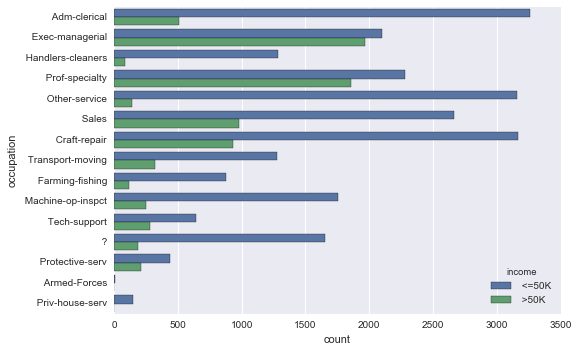

In [33]:
sns.countplot(y='occupation', hue='income', data=training_data)

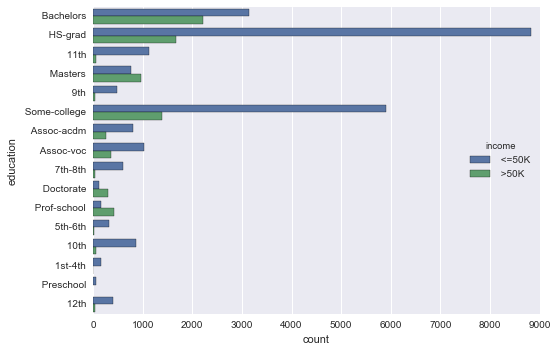

In [34]:
sns.countplot(y='education', hue='income', data=training_data)

In [36]:
#make a meta.json file
import json
meta = {'target_names': list(training_data['income'].unique()),
       'feature_names': list(training_data.columns),
       'categorical_features': {
            column: list(training_data[column])
            for column in training_data.columns
            if training_data[column].dtype == 'object'
    },
}

In [37]:
!pwd

/Users/szeitlin/laborforce


In [38]:
with open('data/meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

In [49]:
from sklearn.datasets.base import Bunch
import os

In [51]:
def create_bunch(root='data', target='income'):
    """ 1) Loads the meta, train and test data from a folder
        2) Removes the target from the categorical features
        
        :param root: parent folder with the following files: 
           meta.json
           training_df.csv
           testing_df.csv
           readme (optional)
        
        :returns: an sklearn Bunch object
    
    """
    with open(os.path.join(root, 'meta.json'), 'r') as f:
        meta = json.load(f)
    
    features = meta['feature_names']
    
    train = pd.read_csv(os.path.join(root, 'training_df.csv'))
    test = pd.read_csv(os.path.join(root, 'testing_df.csv'))
    
    #remove the target
    meta['categorical_features'].pop(target)
    
    #following the tutorial, I hate doing it this way
    return Bunch(
        data = train[names[:-1]],
        target = train[names[-1]],
        data_test = test[names[:-1]],
        target_test = test[names[-1]],
        target_names = meta['target_names'],
        feature_names = meta['feature_names'],
        categorical_features = meta['categorical_features'],
        #DESCR = readme, #assuming this is optional?
    )

In [55]:
dataset = create_bunch()

In [71]:
type(dataset)

sklearn.datasets.base.Bunch

In [67]:
dataset.data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States


In [130]:
type(dataset.data.dtypes)

pandas.core.series.Series

In [138]:
types_as_dict = dataset.data.dtypes.to_dict()
types_as_dict

{'age': dtype('int64'),
 'capital-gain': dtype('int64'),
 'capital-loss': dtype('int64'),
 'education': dtype('O'),
 'education-num': dtype('int64'),
 'fnlwgt': dtype('int64'),
 'hours-per-week': dtype('int64'),
 'marital-status': dtype('O'),
 'native-country': dtype('O'),
 'occupation': dtype('O'),
 'race': dtype('O'),
 'relationship': dtype('O'),
 'sex': dtype('O'),
 'workclass': dtype('O')}

In [141]:
import numpy as np

In [158]:
nonnumbers = [x for x,y in types_as_dict.items() if np.dtype(y)!='int64']

In [159]:
df = dataset.data[nonnumbers]

In [160]:
df.head()

,native-country,race,marital-status,sex,education,occupation,relationship,workclass
0,United-States,White,Never-married,Male,Bachelors,Adm-clerical,Not-in-family,State-gov
1,United-States,White,Married-civ-spouse,Male,Bachelors,Exec-managerial,Husband,Self-emp-not-inc
2,United-States,White,Divorced,Male,HS-grad,Handlers-cleaners,Not-in-family,Private
3,United-States,Black,Married-civ-spouse,Male,11th,Handlers-cleaners,Husband,Private
4,Cuba,Black,Married-civ-spouse,Female,Bachelors,Prof-specialty,Wife,Private


In [170]:
groupfunc = lambda x: x.split('-')[0]
grouped = df.groupby(groupfunc, axis=1)
grouped

In [173]:
grouped.get_group('native').head()

,native-country
0,United-States
1,United-States
2,United-States
3,United-States
4,Cuba


In [123]:
from sklearn.preprocessing import LabelEncoder

In [58]:
gender = LabelEncoder()
gender.fit(dataset.data.sex)
print(gender.classes_)

[' Female' ' Male']


In [60]:
print(gender.transform())

TypeError: transform() missing 1 required positional argument: 'y'

In [61]:
#want to transform multiple columns
from sklearn.base import BaseEstimator, TransformerMixin

In [89]:
class EncodeCategorical(BaseEstimator, TransformerMixin):
    """ Encode a list of columns, or all columns by default
    
    Note that the stupidity of not just initializing with the 
    sklearn dataset Bunch object is inherited, not my idea. 
    
    """
    
    def __init__(self, columns=None):
        """
        :param columns: (optional) list of str
        """
        self.columns = columns
        self.encoders = None
        
    def fit(self, data, target=None):
        """
        :param data: pandas dataframe with named columns
        :param target: str column name
        """
        if self.columns is None:
            self.columns = data.columns
        
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns
        }
        
    def transform(self, data):
        """
        apply the encoders to the dataframe
        
        :return: pandas dataframe with categorical values encoded as numeric
        """
        output=data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])
        return output


In [65]:
train = pd.read_csv('data/training_df.csv')

In [94]:
encoder = EncodeCategorical(dataset.categorical_features.keys())

In [96]:
encoder.fit(dataset.data) #tutorial was wrong here too, they were trying to do fit_transform
                          #in one step, but it doesn't work

In [98]:
transformed = encoder.transform(dataset.data) 

In [99]:
from sklearn.preprocessing import Imputer

In [106]:
class ImputeCategorical(BaseEstimator, TransformerMixin):
    """
    Guesses how to fill missing values in a list of columns, 
    or all columns by default. 
    
    Again, stupid structure here is inherited and this would probably be easier with pandas. 
    """
    def __init__(self, columns=None):
        self.columns = columns
        self.imputer = None
        
    def fit(self, data, target=None):
        """
        :param data: pandas dataframe with named columns
        """
        if self.columns is None:
            self.columns = data.columns
            
        self.imputer = Imputer(missing_values=0, strategy='most_frequent') #great way to create bias!
        self.imputer.fit(data[self.columns])
        
    def transform(self, data):
        """
        apply the imputers to the dataframe
        
        :return: pandas dataframe with missing values filled by the mode
        """
        output = data.copy()
        output[self.columns] = self.imputer.transform(output[self.columns])
        
        return output

In [107]:
imputer = ImputeCategorical(['workclass', 'native-country', 'occupation'])

In [109]:
imputer.fit(transformed)

In [111]:
filled = imputer.transform(transformed)

In [112]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [113]:
yencode = LabelEncoder().fit(dataset.target)

In [115]:
census = Pipeline([
        ('encoder', EncodeCategorical(dataset.categorical_features.keys())),
        ('imputer', ImputeCategorical(['workclass', 'native-country', 'occupation'])),
        ('classifier', LogisticRegression())
    ])

In [117]:
#census.fit(dataset.data, yencode.transform(dataset.target))
#can't do it this way b/c fit_transform isn't working  - not sure why because no tests

In [118]:
lr = LogisticRegression()